# crypto_ml nootebook
Application using machine learning to predict cryptocurrency prices from Binance Exchange API.
App also allow to simulate trading based on predicted moves.


### Project design in form CRISP-DM metodology 
1. Business Understanding
2. Data Understanding
3. Data Preparation 
4. Modeling
5. Evaluation
6. Deployment

### Requirements
Requests - allows you to send HTTP/1.1 requests extremely easily. There’s no need to manually add query strings to your URLs, or to form-encode your POST data. Keep-alive and HTTP connection pooling are 100% automatic, thanks to urllib3.

https://docs.python-requests.org/en/master/

Pandas - open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

https://pandas.pydata.org/docs/

NumPy - the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more.

https://numpy.org/doc/

Matplotlib - comprehensive library for creating static, animated, and interactive visualizations in Python.

https://matplotlib.org/

Scikit-learn - open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities.

https://scikit-learn.org/stable/index.html

In [1]:
# pip install requests 
# pip install pandas
# pip install numpy
# pip install matplotlib
# pip install sklearn
# pip install joblib

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import joblib

## 1. Business Understaning
Scenario: Let's assume we want to invest in cryptocurrencies. Our target is to build a model that will predict for us the next day price for the selected cryptocurrency. We also want to recieve information whether we should make a purchase or stay. 

To predict the price we will use linear regressions with machine learning. The data we use in our model will be taken from the public API provided by Binance Exchange https://github.com/binance/binance-spot-api-docs/blob/master/rest-api.md.

**Important ! The application should not be used for investing without proper knowledge of the cryptocurrency market and should only act as an auxiliary tool. You should also know that the cryptocurrency market is heavily manipulated (Elon Musk's tweets) and dependent on fear and greed (https://alternative.me/crypto/fear-and-greed-index/)**

## 2. Data Understanding

In [2]:
#Binance API URLs

# Binance API endpoint
api_base_endpoint = "https://api.binance.com"

# All current prices 
api_current_price = api_base_endpoint + "/api/v3/ticker/price"

# 1000 days with prices for BTCUSDT (limit - records limit(max-1000), symbol-crypto pair symbols, interval - time interval)
api_historical_price = api_base_endpoint + "/api/v3/klines?limit=1000&symbol=BTCUSDT&interval=1d"

In [3]:
#Use requests to get data from api as json
r_current_price = requests.get(api_current_price)
r_historical_price = requests.get(api_historical_price)

In [4]:
#Use pandas to read api with current prices
current_price = pd.read_json(r_current_price.text)

#Show all availabe pairs on Binance and thei prices (ETHBTC - ETH price in BTC)
current_price

,symbol,price
0,ETHBTC,0.058699
1,LTCBTC,0.003836
2,BNBBTC,0.008378
3,NEOBTC,0.000905
4,QTUMETH,0.003029
...,...,...
1523,MATICAUD,1.454000
1524,DOTRUB,1070.000000
1525,UTKBUSD,0.214600
1526,IOTXBUSD,0.016250


In [5]:
#Use pandas to read api with historical prices selected pair
historical_price = pd.read_json(r_historical_price.text)

#Show all records for the selected pair and time interval
historical_price

,0,1,2,3,4,5,6,7,8,9,10,11
0,1538524800000,6525.79,6549.00,6430.00,6510.00,28451.969138,1538611199999,1.846230e+08,150607,15296.711506,9.927638e+07,0
1,1538611200000,6510.01,6643.46,6505.09,6593.79,20074.300818,1538697599999,1.323487e+08,96824,11077.852512,7.304381e+07,0
2,1538697600000,6591.69,6697.00,6543.08,6635.65,16096.552392,1538783999999,1.062645e+08,86701,8593.749956,5.674922e+07,0
3,1538784000000,6635.65,6651.00,6566.77,6594.27,10939.505391,1538870399999,7.224794e+07,62065,5212.866094,3.443735e+07,0
4,1538870400000,6596.44,6640.00,6525.00,6615.26,17406.831762,1538956799999,1.144891e+08,82844,8768.208280,5.766845e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1624492800000,33675.07,35298.00,32286.57,34663.09,86625.804260,1624579199999,2.925373e+09,1531230,43994.708298,1.486961e+09,0
996,1624579200000,34663.08,35500.00,31275.00,31584.45,116061.130356,1624665599999,3.846121e+09,2094932,55656.156252,1.846078e+09,0
997,1624665600000,31576.09,32730.00,30151.00,32283.65,107820.375287,1624751999999,3.376415e+09,1814051,52978.159256,1.659919e+09,0
998,1624752000000,32283.65,34749.00,31973.45,34700.34,96613.244211,1624838399999,3.199980e+09,1799875,48772.529180,1.616348e+09,0


The data presented may be incomprehensible, but we have information about each column from the Binance documentation :

  **0**  1499040000000,      // Open time \
  **1**  "0.01634790",       // Open \
  **2**  "0.80000000",       // High \
  **3**  "0.01575800",       // Low \
  **4**  "0.01577100",       // Close \
  **5**  "148976.11427815",  // Volume \
  **6**  1499644799999,      // Close time \
  **7**  "2434.19055334",    // Quote asset volume \
  **8**  308,                // Number of trades \
  **9**  "1756.87402397",    // Taker buy base asset volume \
  **10** "28.46694368",      // Taker buy quote asset volume \
  **11** "17928899.62484339" // Ignore. 
  
In our model, we will only need columns in the range 0-5

## 2. Data Preparing

In [6]:
#Delete columns in the range 6-11
del_columns = historical_price.iloc[:,6:]
historical_price_df = historical_price.drop(del_columns, axis=1)

#Rename columns
historical_price_df = historical_price_df.rename(columns={0:'Open time', 1:'Open', 2:'High', 3:'Low', 4:'Close', 5:'Volume'})

#Change time from 'ns' to datetime 
historical_price_df['Open time'] = pd.to_datetime(historical_price_df['Open time'], unit="ms")

#Set time coulmn as index
historical_price_df = historical_price_df.set_index('Open time')

historical_price_df

,Open,High,Low,Close,Volume
Open time,,,,,
2018-10-03,6525.79,6549.00,6430.00,6510.00,28451.969138
2018-10-04,6510.01,6643.46,6505.09,6593.79,20074.300818
2018-10-05,6591.69,6697.00,6543.08,6635.65,16096.552392
2018-10-06,6635.65,6651.00,6566.77,6594.27,10939.505391
2018-10-07,6596.44,6640.00,6525.00,6615.26,17406.831762
...,...,...,...,...,...
2021-06-24,33675.07,35298.00,32286.57,34663.09,86625.804260
2021-06-25,34663.08,35500.00,31275.00,31584.45,116061.130356
2021-06-26,31576.09,32730.00,30151.00,32283.65,107820.375287


<AxesSubplot:xlabel='Open time'>

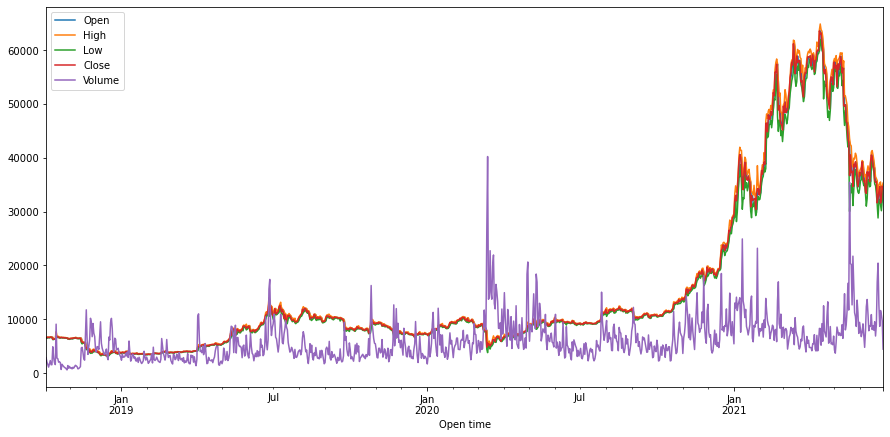

In [7]:
#Show how data looks on chart
plot_price = historical_price_df.copy()
plot_price['Volume'] = plot_price['Volume']/10 #Change Volume size to chart more readable 
plot_price.plot(figsize=(15,7))

In [8]:
#function to automate downloading crypto prices
def download_crypto_prices(symbol='BTCUSDT', interval='1d', limit='1000'):
    api_historical_price = api_base_endpoint + f"/api/v3/klines?limit={limit}&symbol={symbol}&interval={interval}"

    #Use requests to get data from api as json
    r_historical_price = requests.get(api_historical_price)
    
    #Use pandas to read api with current prices
    historical_price = pd.read_json(r_historical_price.text)
    
    #Delete columns in the range 6-11
    del_columns = historical_price.iloc[:,6:]
    historical_price_df = historical_price.drop(del_columns, axis=1)

    #Rename columns
    historical_price_df = historical_price_df.rename(columns={0:'Open time', 1:'Open', 2:'High', 3:'Low', 4:'Close', 5:'Volume'})

    #Change time from 'ns' to datetime 
    historical_price_df['Open time'] = pd.to_datetime(historical_price_df['Open time'], unit="ms")

    #Set time coulmn as index
    historical_price_df = historical_price_df.set_index('Open time')

    return historical_price_df

In [9]:
#all crypto pair with usdt
usdt_crypto = current_price.set_index(['symbol']).filter(like='USDT', axis=0)
usdt_crypto

,price
symbol,
BTCUSDT,34228.8400
ETHUSDT,2008.9200
BNBUSDT,286.6500
BCCUSDT,448.7000
NEOUSDT,30.9210
...,...
TORNUSDT,40.1700
KEEPUSDT,0.2827
ERNUSDT,6.3430


In [10]:
BTCUSDT = download_crypto_prices()
crypto_data= pd.DataFrame(BTCUSDT['Close'])
crypto_data.rename(columns={'Close':'BTCUSDT'})
crypto_data

,Close
Open time,
2018-10-03,6510.00
2018-10-04,6593.79
2018-10-05,6635.65
2018-10-06,6594.27
2018-10-07,6615.26
...,...
2021-06-24,34663.09
2021-06-25,31584.45
2021-06-26,32283.65


In [11]:
for i in usdt_crypto.index:
    data = download_crypto_prices(symbol=i)
    crypto_data[i] = data['Close']
#     crypto_data = pd.concat([crypto_data,download_crypto_prices(symbol=i)['Close']], axis=1)
crypto_data = crypto_data.drop(columns=['Close'],axis=1)
crypto_data

,BTCUSDT,ETHUSDT,BNBUSDT,BCCUSDT,NEOUSDT,LTCUSDT,QTUMUSDT,ADAUSDT,XRPUSDT,EOSUSDT,...,LPTUSDT,NUUSDT,XVGUSDT,ATAUSDT,GTCUSDT,TORNUSDT,KEEPUSDT,ERNUSDT,KLAYUSDT,PHAUSDT
Open time,,,,,,,,,,,,,,,,,,,,,
2018-10-03,6510.00,220.77,10.3136,516.96,18.026,57.56,3.732,0.08088,0.52930,5.6153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-04,6593.79,222.66,10.2982,514.68,17.996,58.42,3.783,0.08164,0.52940,5.8008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-05,6635.65,228.37,10.6756,521.63,18.207,58.93,3.831,0.08339,0.52110,5.8200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-06,6594.27,225.40,10.4289,510.44,17.961,57.96,3.784,0.08151,0.48964,5.7300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-07,6615.26,226.14,10.5852,520.90,18.207,58.33,3.853,0.08464,0.48269,5.7630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-24,34663.09,1989.52,308.6200,NaN,34.978,134.58,6.175,1.36040,0.67310,3.9240,...,23.25,0.2303,0.02259,0.52367,5.70,45.74,0.2704,6.765,1.0157,NaN
2021-06-25,31584.45,1808.82,280.8100,NaN,31.229,125.00,5.512,1.25210,0.61110,3.5333,...,19.89,0.2118,0.02023,0.47000,5.74,38.98,0.2428,6.002,0.9310,0.6460
2021-06-26,32283.65,1829.64,279.6500,NaN,31.167,126.89,5.822,1.25210,0.61620,3.5712,...,18.57,0.2223,0.02076,0.45963,5.80,38.11,0.2458,5.889,0.9341,0.6478


In [12]:
correlation = crypto_data.corr()['BTCUSDT']
print(correlation.describe())
print(f"Mean correlation with BTCUSDT: {round(correlation.mean(),4)*100}%")

count    314.000000
mean       0.595438
std        0.463716
min       -0.884445
25%        0.568200
50%        0.789395
75%        0.876364
max        1.000000
Name: BTCUSDT, dtype: float64
Mean correlation with BTCUSDT: 59.540000000000006%


All crypto USDT pair are strongly correlated BTC. We should train our model using BTC data.

### Linear regression 

**Hypothesis** 
$$ h_{\theta}(x_{m}) = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + ... + \theta_{n}x_{n}$$ \
$$y_{m} = next\_day\_price $$ \
$\;\;x_{n}$ - values \
$\;\;y$ - “output” variable/“target”'variable \
$\;\;n$ - number of features \
$\;\;m$ - number of days 

First model is inspired by https://blog.quantinsti.com/gold-price-prediction-using-machine-learning-python/

$$ h_{\theta}(x_{m}) = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2}$$ 

Where: \
$\;\;x_{1}$ - close mean value for 3 days \
$\;\;x_{2}$ - close mean value for 9 days \
$\;\;y$ - next day close price created from each next day record in our data (close column) 


Second model 
    $$ h_{\theta}(x_{m}) = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \theta_{3}x_{3} + \theta_{4}x_{4}$$ \
Where: \
$\;\;x_{1}$ - Open price \
$\;\;x_{2}$ - Close price \
$\;\;x_{3}$ - Low price \
$\;\;x_{4}$ - Price price \
$\;\;y$ - next day mean price created from each next day mean price (open, close, low, high) record in our data

In [13]:
close_predict = historical_price_df.copy()

#close mean value for 3 days
close_predict['close_3'] = close_predict['Close'].rolling(window=3).mean()

#close mean value for 9 days 
close_predict['close_9'] = close_predict['Close'].rolling(window=9).mean()

#next day close price
close_predict['next_day_close_price'] = close_predict['Close'].shift(-1)

close_predict

,Open,High,Low,Close,Volume,close_3,close_9,next_day_close_price
Open time,,,,,,,,
2018-10-03,6525.79,6549.00,6430.00,6510.00,28451.969138,NaN,NaN,6593.79
2018-10-04,6510.01,6643.46,6505.09,6593.79,20074.300818,NaN,NaN,6635.65
2018-10-05,6591.69,6697.00,6543.08,6635.65,16096.552392,6579.813333,NaN,6594.27
2018-10-06,6635.65,6651.00,6566.77,6594.27,10939.505391,6607.903333,NaN,6615.26
2018-10-07,6596.44,6640.00,6525.00,6615.26,17406.831762,6615.060000,NaN,6673.01
...,...,...,...,...,...,...,...,...
2021-06-24,33675.07,35298.00,32286.57,34663.09,86625.804260,33616.906667,35089.483333,31584.45
2021-06-25,34663.08,35500.00,31275.00,31584.45,116061.130356,33308.536667,34337.865556,32283.65
2021-06-26,31576.09,32730.00,30151.00,32283.65,107820.375287,32843.730000,33692.385556,34700.34


In [14]:
#droping rows with NaN 
close_predict = close_predict.dropna()

close_predict

,Open,High,Low,Close,Volume,close_3,close_9,next_day_close_price
Open time,,,,,,,,
2018-10-11,6630.21,6633.92,6205.00,6252.68,48712.400332,6513.430000,6573.585556,6298.01
2018-10-12,6252.71,6360.00,6209.00,6298.01,29004.071419,6393.896667,6550.031111,6332.93
2018-10-13,6298.00,6345.00,6285.07,6332.93,19098.070025,6294.540000,6521.046667,6339.34
2018-10-14,6332.92,6416.00,6308.00,6339.34,15627.411314,6323.426667,6488.123333,6752.50
2018-10-15,6339.34,7680.00,6300.00,6752.50,90748.031246,6474.923333,6505.704444,6759.27
...,...,...,...,...,...,...,...,...
2021-06-23,32509.56,34881.00,31683.00,33678.07,126966.100563,32598.853333,35698.477778,34663.09
2021-06-24,33675.07,35298.00,32286.57,34663.09,86625.804260,33616.906667,35089.483333,31584.45
2021-06-25,34663.08,35500.00,31275.00,31584.45,116061.130356,33308.536667,34337.865556,32283.65


In [15]:
#copy historical prices without Volume column
mean_predict = historical_price_df[['Open', 'High', 'Low', 'Close']].copy()

#create column for mean value
mean_predict['mean'] = 0

#change he value in the column 'mean' to mean price of the Open, High, Low and Close records
for i in range(len(mean_predict)):
    mean_predict['mean'].iloc[i] = mean_predict.iloc[i,:4].mean()
    
#next day mean price
mean_predict['next_day_mean_price'] = mean_predict['mean'].shift(-1)

#droping rows with NaN 
mean_predict = mean_predict.dropna()

mean_predict  

C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,mean,next_day_mean_price
Open time,,,,,,
2018-10-03,6525.79,6549.00,6430.00,6510.00,6503.6975,6563.0875
2018-10-04,6510.01,6643.46,6505.09,6593.79,6563.0875,6616.8550
2018-10-05,6591.69,6697.00,6543.08,6635.65,6616.8550,6611.9225
2018-10-06,6635.65,6651.00,6566.77,6594.27,6611.9225,6594.1750
2018-10-07,6596.44,6640.00,6525.00,6615.26,6594.1750,6647.7175
...,...,...,...,...,...,...
2021-06-23,32509.56,34881.00,31683.00,33678.07,33187.9075,33980.6825
2021-06-24,33675.07,35298.00,32286.57,34663.09,33980.6825,33255.6325
2021-06-25,34663.08,35500.00,31275.00,31584.45,33255.6325,31685.1850


In [16]:
#function to automate adding columns with close mean values for testing
def prepare_close_df(dataframe):
    close_predict = dataframe.copy()

    #close mean value for 3 days
    close_predict['close_3'] = close_predict['Close'].rolling(window=3).mean()

    #close mean value for 9 days 
    close_predict['close_9'] = close_predict['Close'].rolling(window=9).mean()

    #next day close price
    close_predict['next_day_close_price'] = close_predict['Close'].shift(-1)
    
    #droping rows with NaN 
    close_predict = close_predict.dropna()

    return close_predict

#function to automate adding column with mean values for testing
def prepare_mean_df(dataframe):
    #copy historical prices without Volume column
    mean_predict = dataframe.copy()

    #create column for mean value
    mean_predict['mean'] = 0

    #change he value in the column 'mean' to mean price of the Open, High, Low and Close records
    for i in range(len(mean_predict)):
        mean_predict['mean'].iloc[i] = mean_predict.iloc[i,:4].mean()
    
    mean_predict['next_day_mean_price'] = mean_predict['mean'].shift(-1)
    mean_predict = mean_predict.dropna()                                                                 
                                                                     
    return mean_predict

# def add_next_day_column(dataframe, day=1):
#     mean_predict = add_mean_column(dataframe)
#     #next day mean price
#     mean_predict['next_day_mean_price'] = mean_predict['mean'].shift(-1)
#     mean_predict['next_7day_mean_price'] = mean_predict['mean'].shift(-7)
#     mean_predict['next_30day_mean_price'] = mean_predict['mean'].shift(-30)

#     #droping rows with NaN 
#     mean_predict = mean_predict.dropna()

#     return mean_predict  

## 3. Modeling
To create and evaluate the model we will use Sckit-learn library which will do all the linear regression calculations for us.
We will train two our models, compare them and choose a more exact onet.

Next day close price model:

In [17]:
#randomly split data on 80% train set and 20% test set
train_close_set, test_close_set = train_test_split(close_predict, test_size=0.2, random_state=42)

#training data
X_close_train = train_close_set[['close_3', 'close_9']]
y_close_train = train_close_set['next_day_close_price']

#test data
X_close_test = test_close_set[['close_3', 'close_9']]
y_close_test = test_close_set['next_day_close_price']

#import linear regression model from Scikit-learn
close_price_lr_model = LinearRegression()

#fit linear model
close_price_lr_model.fit(X_close_train, y_close_train)

LinearRegression()

In [18]:
#function using cross validation to test our model
def cross_val_test(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
    cross_scores = np.sqrt(-scores)
    return f"""Results: {cross_scores}\nMean: {cross_scores.mean()}\nStandard devation: {cross_scores.std()}"""

In [19]:
print(cross_val_test(close_price_lr_model, X_close_train, y_close_train))

close_lr_model_score = close_price_lr_model.score(X_close_test, y_close_test)*100
print(f"Predict score on test sets: {float(close_lr_model_score.round(2))} %\n" )
print(f"Next day price h(x) = {close_price_lr_model.intercept_.round(2)} + {close_price_lr_model.coef_[0].round(2)} * 3 Days Moving Average (x1) \
+ {close_price_lr_model.coef_[1].round(2)} * 9 Days Moving Average (x2)")

joblib.dump(close_price_lr_model, 'close_price_lr_model.pkl')

Results: [1311.89567757 1133.57599672  901.63345886 1094.98502611 1027.52762471
 1025.47916096  957.25709717 1489.53801756  997.81600671 1246.68570069]
Mean: 1118.6393767055913
Standard devation: 172.2807487875697
Predict score on test sets: 99.56 %

Next day price h(x) = 95.79 + 1.23 * 3 Days Moving Average (x1) + -0.24 * 9 Days Moving Average (x2)


['close_price_lr_model.pkl']

Next day mean price model:

In [20]:
#randomly split data on 80% train set and 20% test set
train_mean_set, test_mean_set = train_test_split(mean_predict, test_size=0.2, random_state=42)

X_mean_train = train_mean_set[['Open', 'High', 'Low', 'Close']]
y_mean_train = train_mean_set['next_day_mean_price']

X_mean_test = test_mean_set[['Open', 'High', 'Low', 'Close']]
y_mean_test = test_mean_set['next_day_mean_price']

mean_price_lr_model = LinearRegression()
mean_price_lr_model.fit(X_mean_train, y_mean_train)

print(cross_val_test(mean_price_lr_model, X_mean_train, y_mean_train))

mean_lr_model_score = mean_price_lr_model.score(X_mean_test, y_mean_test)*100
print(f"Predict score on test sets: {float(mean_lr_model_score.round(2))} %\n" )
print(f"Next day price h(x) = {mean_price_lr_model.intercept_.round(2)} + {mean_price_lr_model.coef_[0].round(2)} * 3 Days Moving Average (x1) \
+ {mean_price_lr_model.coef_[1].round(2)} * 9 Days Moving Average (x2)")

joblib.dump(mean_price_lr_model, 'mean_price_lr_model.pkl')

Results: [758.58379019 353.30168069 373.42715595 499.53986034 341.95224412
 611.24923557 576.31486743 603.55201264 426.09192944 519.98671037]
Mean: 506.3999486733105
Standard devation: 127.96937599912586
Predict score on test sets: 99.86 %

Next day price h(x) = 31.31 + 0.05 * 3 Days Moving Average (x1) + -0.06 * 9 Days Moving Average (x2)


['mean_price_lr_model.pkl']

## 5. Evaluation

Test models on new data

In [21]:
ETHUSDT = download_crypto_prices('ETHUSDT')
ETHUSDT_close_df = prepare_close_df(ETHUSDT)
ETHUSDT_mean_df = prepare_mean_df(ETHUSDT) 

eth_close_lr_model = joblib.load('close_price_lr_model.pkl')
eth_mean_lr_model = joblib.load('mean_price_lr_model.pkl')

X_close_df = ETHUSDT_close_df[['close_3', 'close_9']]
y_close_df = ETHUSDT_close_df['next_day_close_price']
X_mean_df = ETHUSDT_mean_df[['Open', 'High', 'Low', 'Close']]
y_mean_df = ETHUSDT_mean_df['next_day_mean_price']

eth_close_price = eth_close_lr_model.predict(X_close_df)
print(cross_val_test(eth_close_lr_model, X_close_df, y_close_df))

eth_mean_price = eth_mean_lr_model.predict(X_mean_df)
print(cross_val_test(eth_mean_lr_model, X_mean_df, y_mean_df))

C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Results: [ 10.20833165   7.25011184  14.35157385  10.26345234   8.94157773
  15.32793273  16.93400959  24.18272532  93.76504979 212.63274875]
Mean: 41.385751356889536
Standard devation: 62.0735924123722
Results: [  5.17668863   3.13755382   6.83922087   4.71030665   3.99241391
   7.23209157   6.64612251  10.98008399  48.87665457 107.29531225]
Mean: 20.48864487530995
Standard devation: 31.689029159734055


Model based on mean values gives smaller mean squarred error

In [22]:
predicted_df = pd.merge(left=ETHUSDT_mean_df, right=pd.DataFrame(eth_mean_price), on=ETHUSDT_mean_df.index)
predicted_df = predicted_df.rename(columns={'key_0':'Open time', 0:'predicted price'}).set_index(['Open time'])
predicted_df

,Open,High,Low,Close,Volume,mean,next_day_mean_price,predicted price
Open time,,,,,,,,
2018-10-03,225.70,226.43,216.51,220.77,275609.26221,222.3525,222.4950,251.913363
2018-10-04,220.67,227.16,219.49,222.66,158137.42967,222.4950,225.5325,253.486904
2018-10-05,222.66,231.75,219.35,228.37,137730.35786,225.5325,226.4425,259.097828
2018-10-06,228.36,228.86,223.15,225.40,100257.56970,226.4425,225.1900,256.542517
2018-10-07,225.39,227.75,221.48,226.14,74733.67253,225.1900,228.2950,257.203206
...,...,...,...,...,...,...,...,...
2021-06-23,1879.29,2045.00,1821.95,1968.14,918612.30494,1928.5950,1969.7175,1990.109385
2021-06-24,1967.95,2036.61,1884.79,1989.52,701231.67478,1969.7175,1902.3900,2016.452812
2021-06-25,1989.53,2019.99,1791.22,1808.82,858808.54767,1902.3900,1802.1825,1836.965871


## 6. Deployment

Predict tomorrow price for BTC

In [23]:
BTCUSDT_predict = download_crypto_prices('BTCUSDT').tail(1)
btc_mean_lr_model = joblib.load('mean_price_lr_model.pkl')
X = BTCUSDT_predict[['Open', 'High', 'Low', 'Close']]
btc_price = btc_mean_lr_model.predict(X)

btc_result_df = pd.merge(left=BTCUSDT_predict, right=pd.DataFrame(btc_price), on=BTCUSDT_predict.index)
btc_result_df = btc_result_df.rename(columns={'key_0':'Open time', 0:'predicted next day price'}).set_index(['Open time'])
btc_result_df

,Open,High,Low,Close,Volume,predicted next day price
Open time,,,,,,
2021-06-28,34702.49,35297.71,33960.0,34216.1,44367.442628,34191.835976


## 6. Deployment

In [24]:
mean_predict_result = download_crypto_prices('BTCUSDT')

mean_predict_result = mean_predict_result.iloc[:,0:4]
mean_predict_result['mean'] = 0

for i in range(len(mean_predict_result)):
    mean_predict_result['mean'].iloc[i] = mean_predict_result.iloc[i,:4].mean()

model = joblib.load('mean_price_lr_model.pkl')
    
mean_predict_result['predicted_crypto_price'] = model.predict(mean_predict_result[['Open', 'High', 'Low', 'Close']])
mean_predict_result

C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,mean,predicted_crypto_price
Open time,,,,,,
2018-10-03,6525.79,6549.00,6430.00,6510.00,6503.6975,6536.144143
2018-10-04,6510.01,6643.46,6505.09,6593.79,6563.0875,6613.992134
2018-10-05,6591.69,6697.00,6543.08,6635.65,6616.8550,6657.340740
2018-10-06,6635.65,6651.00,6566.77,6594.27,6611.9225,6620.363844
2018-10-07,6596.44,6640.00,6525.00,6615.26,6594.1750,6640.341825
...,...,...,...,...,...,...
2021-06-24,33675.07,35298.00,32286.57,34663.09,33980.6825,34599.513488
2021-06-25,34663.08,35500.00,31275.00,31584.45,33255.6325,31543.610152
2021-06-26,31576.09,32730.00,30151.00,32283.65,31685.1850,32245.522677


In [25]:
mean_predict_result['move'] = np.where(
    mean_predict_result['mean'] < mean_predict_result['predicted_crypto_price'], "Buy", "Stay"
)
mean_predict_result.tail()

,Open,High,Low,Close,mean,predicted_crypto_price,move
Open time,,,,,,,
2021-06-24,33675.07,35298.00,32286.57,34663.09,33980.6825,34599.513488,Buy
2021-06-25,34663.08,35500.00,31275.00,31584.45,33255.6325,31543.610152,Stay
2021-06-26,31576.09,32730.00,30151.00,32283.65,31685.1850,32245.522677,Buy
2021-06-27,32283.65,34749.00,31973.45,34700.34,33426.6100,34595.174830,Buy
2021-06-28,34702.49,35297.71,33960.00,34216.10,34544.0750,34191.835976,Stay


In [26]:
def buys_simulator_df(df=mean_predict_result, money_buys=10):
    money_spend = 0
    buys = 0
    bought_coins = 0
    for i in range(len(df)):
        if df['move'].iloc[i] == 'Buy':
            buys +=1
            bought_coins += money_buys / df['mean'].iloc[i]
            money_spend += money_buys
    coin_price =df['mean'].iloc[-1]
    fortune = (bought_coins * coin_price).round(2)
    profit = (fortune - money_spend).round(2)
    rate_of_return = ((profit / money_spend) * 100).round(2)
    result_df = pd.DataFrame(data={
        'Money for buys': money_buys,
        'Buys number': buys,
        'Bought coins': bought_coins,
        'Money spend': money_spend,
        'Current coin price': coin_price,
        'Fortune': fortune,
        'profit': profit,
        'rate of return': rate_of_return,
    }, index=[0])
    return result_df

In [27]:
buys_simulator_df(money_buys = 100)

,Money for buys,Buys number,Bought coins,Money spend,Current coin price,Fortune,profit,rate of return
0,100,654,8.273408,65400,34544.075,285797.21,220397.21,337.0


In [28]:
def buys_sales_simulator_df(df=mean_predict_result, money_buys=10, money_sales=10):
    money_spend = 0
    buys = 0
    bought_coins = 0
    sales = 0
    for i in range(len(df)):
        if df['move'].iloc[i] == 'Buy':
            buys +=1
            bought_coins += money_buys / df['mean'].iloc[i]
            money_spend += money_buys
        else:
            sales += 1
            bought_coins -= money_sales / df['mean'].iloc[i]
            money_spend -= money_sales 
    coin_price = df['mean'].iloc[-1]
    if bought_coins<0 or money_spend<0:
        return "Negative Values"
    fortune = (bought_coins * coin_price).round(2)
    profit = (fortune - money_spend).round(2)
    rate_of_return = ((profit / money_spend) * 100).round(2)
    result_df = pd.DataFrame(data={
        'Money for buys': money_buys,
        'Money for sales': money_sales,
        'Buys number': buys,
        'Sales number': sales,
        'Bought coins': bought_coins,
        'Money spend': money_spend,
        'Current coin price': coin_price,
        'Fortune': fortune,
        'profit': profit,
        'rate of return': rate_of_return,
    }, index=[0])
    return result_df

In [29]:
buys_sales_simulator_df()

,Money for buys,Money for sales,Buys number,Sales number,Bought coins,Money spend,Current coin price,Fortune,profit,rate of return
0,10,10,654,346,0.478221,3080,34544.075,16519.7,13439.7,436.35
